<a href="https://colab.research.google.com/github/Ahmadar91/ML/blob/main/Lab_4_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [23]:
%matplotlib inline

In [ ]:
%pip install matplotlib 
%pip install pandas 
%pip install torch 
%pip install torchvision

In [24]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import numpy as np

Define a couple of parameters "meaningfully" -> consult the tutorial for help
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

We want to use the MNIST dataset (not CIFAR)!


In [25]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5

Now we need to load the MNIST dataset using the dataloader functions
for CIFAR the following transforms are used:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

It turns out that for MNIST this transform works better due to the difference in value range:
torchvision.transforms.Compose([
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(
(0.1307,), (0.3081,))
])

Observe that the RGB image for CIFAR needs three channels (all 0.5) MNIST has only one gray channel!


In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=False
)

I recommend testing is the dataloader worked, render one of the images and put the numeral in the title


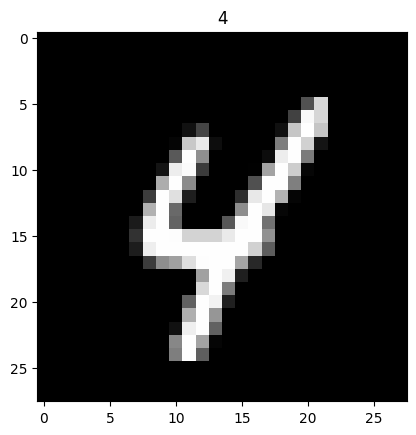

In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

image = image * 0.5 + 0.5

image = image.numpy()

plt.imshow(image.squeeze(), cmap="gray")

plt.title(str(label.item()))

plt.show()

Now we need to define our convolutional neural network, is should have 1 convolutional layer (I recommend handing over the kernel size as a parameter at construction) and 1 pooling layer followed by other normal layers

You only have one in channel (gray)

the number of out channels is up to you - pick wisely, the same applies to the other weights of the other layers


In [28]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        print("kernel size", self.kernel_size)
        input_size = 28
        output_channels_value = 3
        print("output_channels_value", output_channels_value)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=output_channels_value,
            kernel_size=self.kernel_size,
        )
        self.pool = nn.MaxPool2d(self.kernel_size)
        conv_out_size = (input_size - self.kernel_size) + 1
        print(f"conv_out_size: {conv_out_size}")
        pool_out_size = ((conv_out_size - self.kernel_size) // self.kernel_size) + 1
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = (
            output_channels_value * pool_out_size * pool_out_size
        )
        print("input_size_after_conv_and_pool", input_size_after_conv_and_pool)
        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.features = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

Now implement the training and testing code. Toggle the training and testing for the convolutional neural network
using the model.train() and model.eval() functions!
Choose your own optimiser and loss function!

Collect training and testing accuracy over training


In [35]:
trainAccuracy = list()
testAccuracy = list()

model = MyCNN(5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

kernel size 5
output_channels_value 3
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 48


In [36]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    return train_accuracy


def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy


for epoch in range(n_epochs):
    train_accuracy = train(model, train_loader, criterion, optimizer)
    trainAccuracy.append(train_accuracy)

    test_accuracy = test(model, test_loader)
    testAccuracy.append(test_accuracy)

    print(
        f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
    )

print("Finished Training")

Epoch 1, Train Accuracy: 71.94%, Test Accuracy: 90.22%
Epoch 2, Train Accuracy: 90.48%, Test Accuracy: 92.28%
Epoch 3, Train Accuracy: 92.43%, Test Accuracy: 93.47%
Epoch 4, Train Accuracy: 93.16%, Test Accuracy: 94.30%
Epoch 5, Train Accuracy: 93.51%, Test Accuracy: 93.79%
Finished Training


now we plot both to test for overfitting


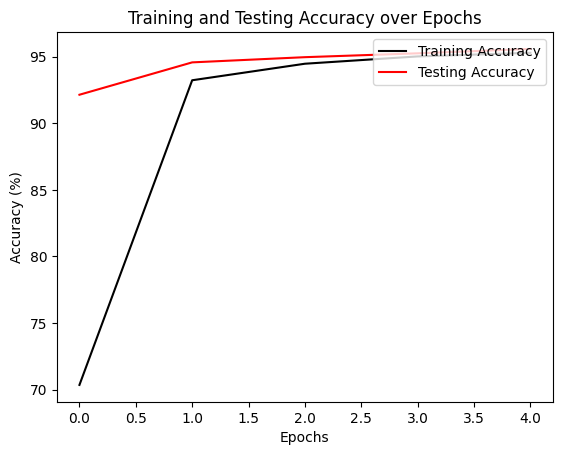

In [31]:
plt.plot(trainAccuracy, "k", label="Training Accuracy")
plt.plot(testAccuracy, "r", label="Testing Accuracy")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")

plt.show()

Tune the parameters above until you get a good training efficiency and not too much overfitting, also do not train more than neccesary

In the next cell we define the kernel sizes we want to test


kernel size 2
conv_out_size: 27
pool_out_size: 13
input_size_after_conv_and_pool 2704
Epoch 1, Train Accuracy: 82.22%, Test Accuracy: 88.92%
Epoch 2, Train Accuracy: 91.94%, Test Accuracy: 93.85%
Epoch 3, Train Accuracy: 94.09%, Test Accuracy: 94.43%
Epoch 4, Train Accuracy: 95.57%, Test Accuracy: 96.08%
Epoch 5, Train Accuracy: 96.47%, Test Accuracy: 96.69%
Finished Training


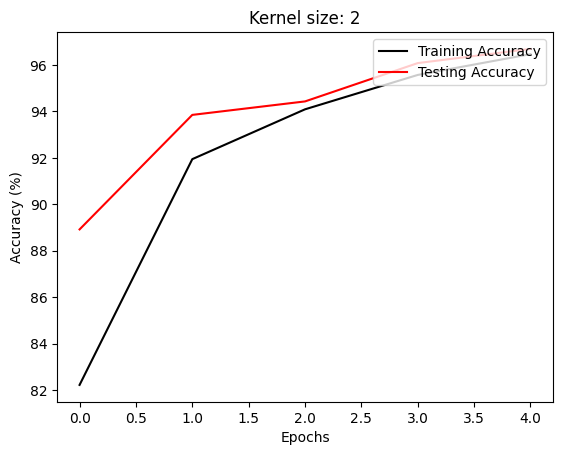

kernel size 3
conv_out_size: 26
pool_out_size: 8
input_size_after_conv_and_pool 1024
Epoch 1, Train Accuracy: 85.06%, Test Accuracy: 94.72%
Epoch 2, Train Accuracy: 95.28%, Test Accuracy: 96.56%
Epoch 3, Train Accuracy: 96.58%, Test Accuracy: 97.14%
Epoch 4, Train Accuracy: 97.24%, Test Accuracy: 97.53%
Epoch 5, Train Accuracy: 97.60%, Test Accuracy: 97.44%
Finished Training


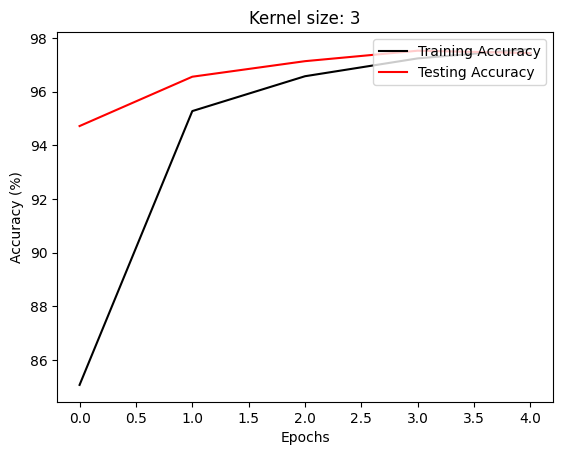

kernel size 4
conv_out_size: 25
pool_out_size: 6
input_size_after_conv_and_pool 576
Epoch 1, Train Accuracy: 83.26%, Test Accuracy: 95.55%
Epoch 2, Train Accuracy: 95.88%, Test Accuracy: 96.90%
Epoch 3, Train Accuracy: 96.93%, Test Accuracy: 97.35%
Epoch 4, Train Accuracy: 97.42%, Test Accuracy: 97.49%
Epoch 5, Train Accuracy: 97.71%, Test Accuracy: 97.79%
Finished Training


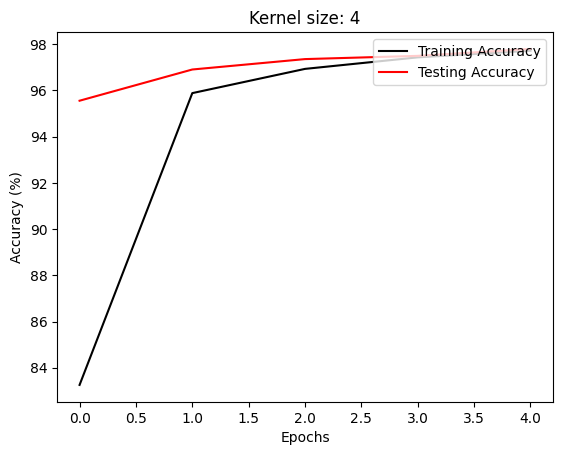

kernel size 5
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 256
Epoch 1, Train Accuracy: 79.47%, Test Accuracy: 94.34%
Epoch 2, Train Accuracy: 95.17%, Test Accuracy: 96.61%
Epoch 3, Train Accuracy: 96.34%, Test Accuracy: 96.98%
Epoch 4, Train Accuracy: 96.95%, Test Accuracy: 96.93%
Epoch 5, Train Accuracy: 97.25%, Test Accuracy: 97.58%
Finished Training


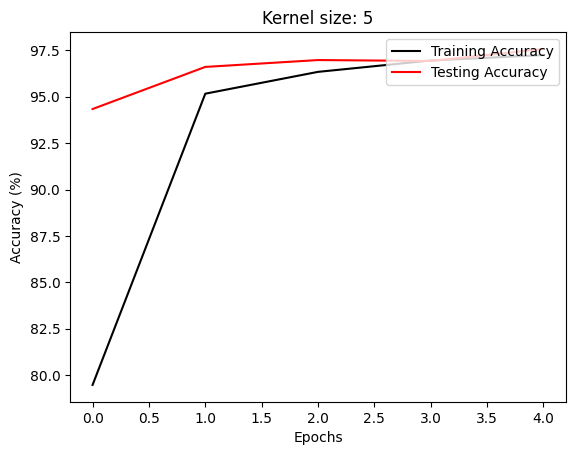

In [63]:
kernelSizes = [2, 3, 4, 5]

for kernelSize in kernelSizes:
    trainAccuracy = list()
    testAccuracy = list()

    model = MyCNN(kernelSize)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        train_accuracy = train(model, train_loader, criterion, optimizer)
        trainAccuracy.append(train_accuracy)

        test_accuracy = test(model, test_loader)
        testAccuracy.append(test_accuracy)

        print(
            f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
        )

    print("Finished Training")
    plt.plot(trainAccuracy, "k", label="Training Accuracy")
    plt.plot(testAccuracy, "r", label="Testing Accuracy")
    plt.title("Kernel size: " + str(kernelSize))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="bottom right")
    plt.show()

Compare the plots from above and explain which kernel size worked best, hypothesize about why?


Your answer here:

1. **Kernel Size 2x2**:
   - **Training Accuracy**: Starts at 82.22% and reaches 96.47% by the end.
   - **Testing Accuracy**: Starts at 88.92% and reaches 96.69% by the end.
   - **Output Feature Map Dimensions**: 2704 (after pooling)
2. **Kernel Size 3x3**:
   - **Training Accuracy**: Starts at 85.06% and reaches 97.60% by the end.
   - **Testing Accuracy**: Starts at 94.72% and reaches 97.44% by the end.
   - **Output Feature Map Dimensions**: 1024 (after pooling)
3. **Kernel Size 4x4**:
   - **Training Accuracy**: Starts at 83.26% and reaches 97.71% by the end.
   - **Testing Accuracy**: Starts at 95.55% and reaches 97.79% by the end.
   - **Output Feature Map Dimensions**: 576 (after pooling)
4. **Kernel Size 5x5**:
   - **Training Accuracy**: Starts at 79.47% and reaches 97.25% by the end.
   - **Testing Accuracy**: Starts at 94.34% and reaches 97.58% by the end.
   - **Output Feature Map Dimensions**: 256 (after pooling)

**Analysis**:

- The **3x3** kernel size starts off with a relatively high accuracy and maintains a close gap between training and testing accuracy, suggesting a good balance between bias and variance.
- The **4x4** kernel achieves the highest test accuracy by the end of the training (97.79%) among all the kernel sizes.
- **2x2** has the largest feature map dimensions after pooling, which means it has a lot of parameters to learn. This might make the model more prone to overfitting, especially with smaller datasets.
- **5x5** starts with the lowest training accuracy (79.47%) but eventually catches up by the end. The smaller feature map dimensions after pooling mean fewer parameters, which might make it less prone to overfitting but potentially more prone to underfitting.

**Conclusion**:

- The **4x4** kernel appears to be the most optimal in terms of test accuracy. However, the differences in test accuracy between 3x3, 4x4, and 5x5 are minimal, suggesting that all three sizes work fairly well for this dataset.
- The choice of kernel size often depends on the specific characteristics of the dataset. For intricate datasets with fine-grained patterns, smaller kernels might be more suitable, while for datasets with broader features, larger kernels might be better.

- In this case, it seems the intermediate kernel sizes (3x3 and 4x4) are most effective, which aligns with the general observation in many deep learning tasks where 3x3 kernels are often found to be a good compromise between capturing local features and computational efficiency.


Now pick a random image and pipe it through your trained CNN
extract the output of the convolutional layer for each output channel and visualize that as an image
Observe that the template CNN has a self.features variable ... that might help here


In [37]:
kernel_values = model.conv1.weight.detach().numpy()
print("Kernel Values:")
print(kernel_values)

Kernel Values:
[[[[-0.4902651  -0.5004486  -0.10207672  0.41655722  0.6570762 ]
   [-0.5049649   0.2502791   0.66762996  0.6210175  -0.12908946]
   [-0.09730345  0.5753444   0.63194     0.16294602 -0.6828694 ]
   [ 0.50754666  0.46545866  0.02526639 -0.3603978  -0.24750149]
   [ 0.2988434  -0.20645969 -0.29119116 -0.15171985 -0.17005964]]]


 [[[-0.27479944 -0.10617729 -0.34235904 -0.15489072 -0.5582376 ]
   [-0.3339993  -0.17287794 -0.09730767 -0.35138136 -0.28837675]
   [-0.23613098 -0.10155085 -0.27278787 -0.23443292 -0.17535317]
   [-0.25929654 -0.2210254  -0.31052956 -0.18945222 -0.17238921]
   [-0.5720999  -0.28083977 -0.2088676  -0.13695788 -0.14278257]]]


 [[[ 0.17937537  0.32810023 -0.12950367 -0.4317333  -0.06851491]
   [-0.31448382  0.3776288   0.56331885  0.57098377  0.6435039 ]
   [-0.19067411  0.2727453   0.51292044  0.62882984  0.7074467 ]
   [-0.39096293 -0.02301131 -0.07133707 -0.40029618 -0.529344  ]
   [-0.6722453  -0.7807599  -0.94628114 -0.740307   -0.6736379 ]]]]

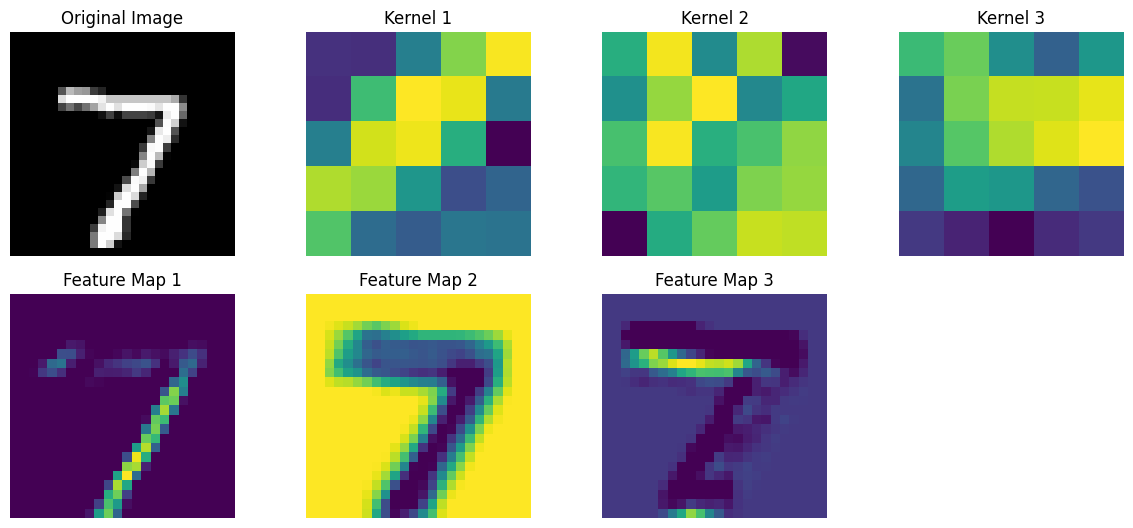

In [38]:
kernel_values = model.conv1.weight.detach().numpy()

image, _ = next(iter(test_loader))
image = image[0].unsqueeze(0)

model(image)
feature_maps = model.features.squeeze(0).detach().numpy()

num_kernels = kernel_values.shape[0]
num_feature_maps = feature_maps.shape[0]

plt.figure(figsize=(12, 8))

plt.subplot(3, max(num_kernels, num_feature_maps) + 1, 1)
plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

for i in range(num_kernels):
    plt.subplot(3, max(num_kernels, num_feature_maps) + 1, i + 2)
    plt.imshow(kernel_values[i, 0], cmap="viridis")
    plt.title(f"Kernel {i+1}")
    plt.axis("off")

for i in range(num_feature_maps):
    plt.subplot(
        3,
        max(num_kernels, num_feature_maps) + 1,
        i + max(num_kernels, num_feature_maps) + 2,
    )
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

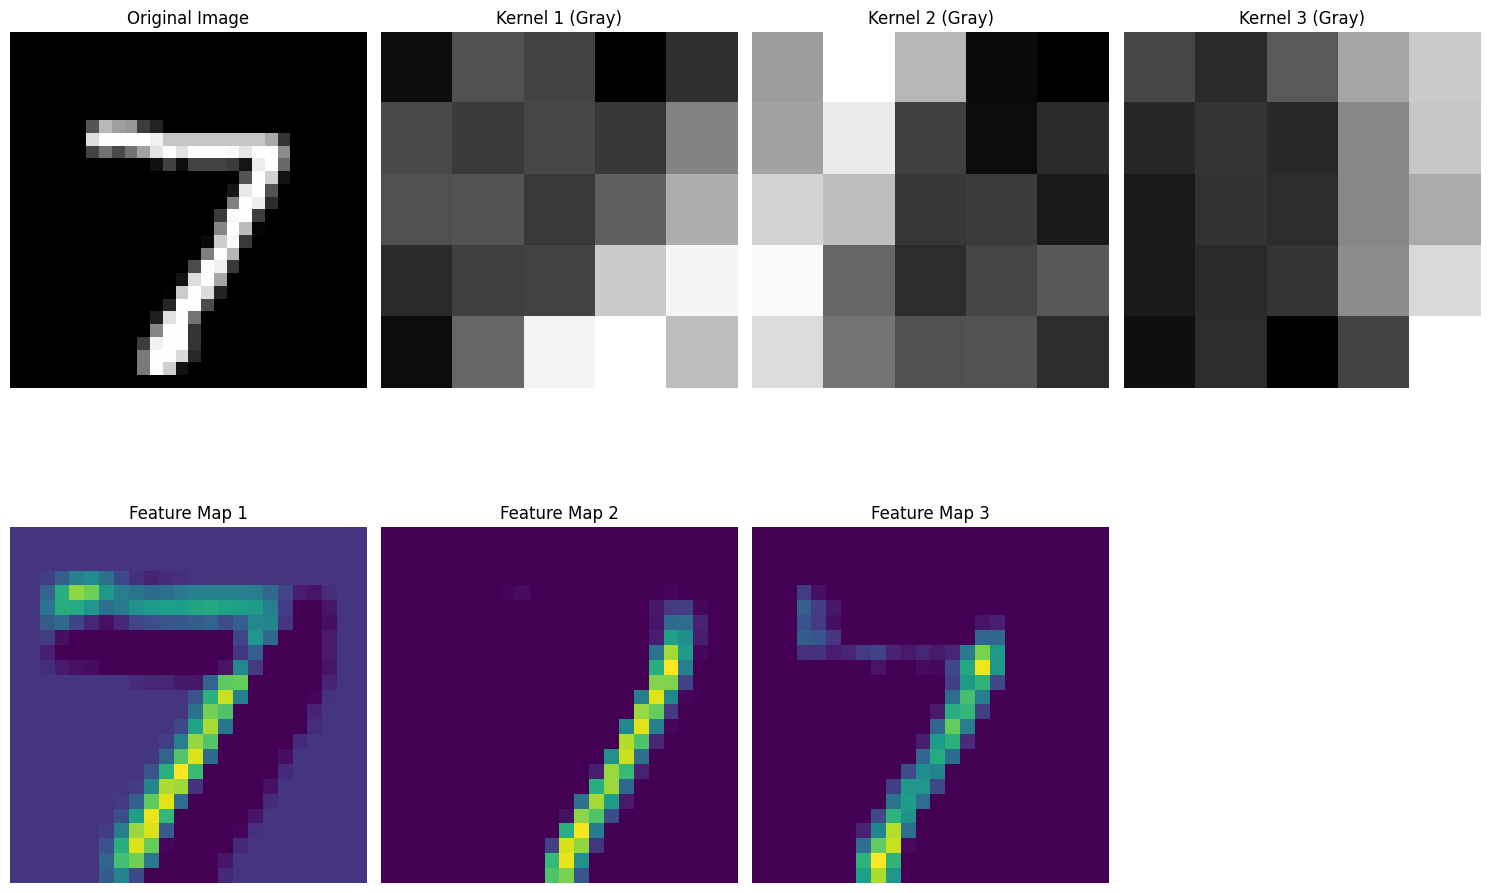

In [22]:
model.eval()

image, _ = next(iter(test_loader))
input_image = image[0].unsqueeze(0)
output = model(input_image)
feature_maps = model.features.squeeze(0).detach().numpy()

kernel_values = model.conv1.weight.detach().numpy()

num_kernels = kernel_values.shape[0]
num_feature_maps = feature_maps.shape[0]

plt.figure(figsize=(15, 15))

plt.subplot(3, max(num_kernels, num_feature_maps) + 1, 1)
plt.imshow(input_image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

for i in range(num_kernels):
    plt.subplot(3, max(num_kernels, num_feature_maps) + 1, i + 2)
    plt.imshow(kernel_values[i, 0], cmap="gray")
    plt.title(f"Kernel {i+1} (Gray)")
    plt.axis("off")

for i in range(num_feature_maps):
    plt.subplot(
        3,
        max(num_kernels, num_feature_maps) + 1,
        i + max(num_kernels, num_feature_maps) + 2,
    )
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Can you guess the feature that each channel extracted? short text below


Your answer here:

1. **Kernel 1 (Negative values prevalent)**:

   - The kernel has predominantly negative values, especially in its top-left and bottom-left corners. This means it will respond to the opposite of those values.
   - It might be detecting top-right or bottom-right oriented edges or bright patterns in those areas of the image.

2. **Kernel 2 (Positive values prevalent)**:

   - This kernel has positive values, especially in its top and bottom-left corners.
   - High activations from this kernel might indicate the presence of top-left or bottom-left oriented edges or patterns in the image.

3. **Kernel 3 (Combination of Positive and Negative values)**:
   - The kernel has a combination of positive values on the right and negative values on the left.
   - This suggests that it might be sensitive to vertical edges, especially those transitioning from dark to light from left to right.

- The digit '7' typically has a horizontal edge on the top and a diagonal edge going from top-left to bottom-right.
- Given the kernels:
  - **Kernel 1** might activate on the horizontal edge of the '7' due to its sensitivity to bright patterns or edges in the top-right or bottom-right.
  - **Kernel 2** might not have a strong activation for '7' since '7' lacks dominant features in the top-left or bottom-left corners. However, if it does activate, it might be due to the top horizontal edge.
  - **Kernel 3** could possibly activate on the diagonal part of '7' since it's sensitive to vertical edges.
